## Домашее задание №1 по NLP

Выполнили:
* Кухарева Елизавета
* Андрианова Екатерина
* Жариков Дмитрий
* Свиридов Иван

## Часть 1. [2 балла] Эксплоративный анализ 

In [4]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import re

from tqdm import tqdm
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

1. Найдите топ-1000 слов по частоте без учета стоп-слов.

100%|█████████████████████████████████████| 36225/36225 [08:55<00:00, 67.64it/s]


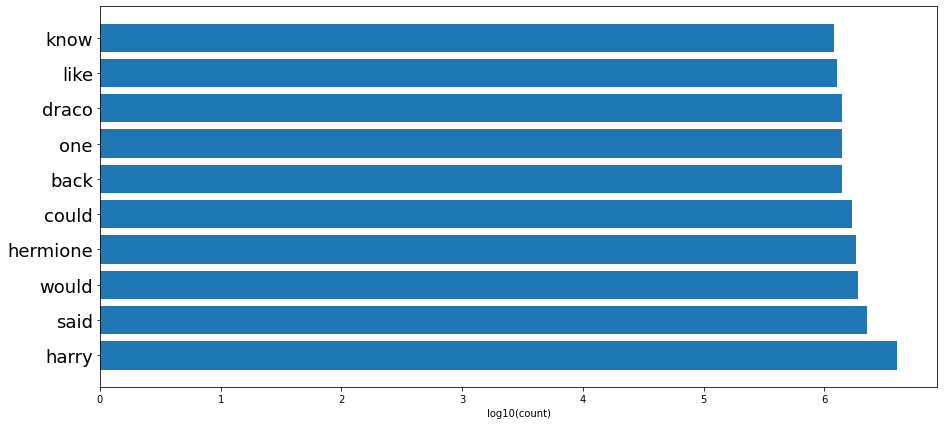

,n_text,n_count
harry,28044,4000492
said,31629,2262244
would,34316,1904626
hermione,20473,1831472
could,34296,1688251
back,33841,1400262
one,34735,1400046
draco,15162,1389977
like,34055,1275266
know,32831,1203899


In [1]:
def get_top_words() -> pd.DataFrame:
    """
        Список топовых слов
    """
    input_folder = 'hpac_source/'

    stop_words = set(stopwords.words('english'))
    
    tokenizer = RegexpTokenizer(r'\w+')

    word_counter = {}
    for file in tqdm(os.listdir(input_folder)):
        current_file = pd.read_csv(input_folder+file, sep='\t', header=None)
        text = current_file[0]
        
        # Проверяю что формат верный
        assert len(text)==1
        
        text = text.loc[0] 
        current_counter = Counter()
        for w in tokenizer.tokenize(text):
            current_counter[w] += 1
        
        for w, v in current_counter.items():
            w = w.lower()
            if w in stop_words or len(w)<=2:
                continue
            
            if w not in word_counter:
                word_counter[w] = {'n_text': 0, 'n_count': 0}
            word_counter[w]['n_text'] += 1
            word_counter[w]['n_count'] += v
        
    return pd.DataFrame(word_counter).T.sort_values('n_count', ascending = False)


def vizualize_top_10(df: pd.DataFrame) -> None:
    """
        Визуализация топ 10
    """
    n = 10
    plt.figure(figsize = (15, 7))
    df_top_10 = df[:n].reset_index()
    plt.barh(df_top_10.index,
            df_top_10['n_count'].apply(np.log10)
           )
    plt.yticks(df_top_10.index, df_top_10['index'], size=18)
    plt.xlabel("log10(count)")
    plt.show()
    

df_top_words = get_top_words()
vizualize_top_10(df_top_words)
df_top_words[:20]

2. Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия. 

>
     1) Регулярками нагенерируем кандидатов (регулярки работают по регистру и/или ключевым словам)
     
     2) Почистим все руками

In [2]:
def get_data() -> pd.DataFrame:
    """
        Загружает данные из папки
    """
    input_folder = 'fanfiction_texts/'
    result_data = pd.DataFrame()
    for file in tqdm(os.listdir(input_folder)):
        try:
            current_file = pd.read_csv(input_folder+file, sep='\t', header=None, 
                                       on_bad_lines='skip')
            result_data = pd.concat((result_data ,current_file))
        except:
            continue
    
    result_data.dropna(axis=1, inplace=True)
    return result_data.rename(columns = {0: "text"}).reset_index(drop=True)

def get_candidates(text):
    """
        Регулярки которые выцепляют кандидатов
    """
    ptrn_name = r"[A-Z][a-z]+,?\s+"
    ptrn_surname = r"[A-Z][a-z]+"

    name_list       = re.findall(ptrn_name, text)
    full_names_list = re.findall(ptrn_name + ptrn_surname, text)
    
    prof_name_list = []
    for ptrn in ["Professor\s*[A-z]+\s", 
                 "Prof\.\s*[A-z]+\s",
                 "Prof\s*[A-z]+\s",
                 "Professor\s*[A-z]+\s[A-z]+\s", 
                 "Prof\.\s*[A-z]+\s[A-z]+\s",
                 "Prof\s*[A-z]+\s[A-z]+\s"]:
        prof_name_list  = re.findall(ptrn, text)
    res = {"name": name_list,
           "full_name": full_names_list,
           "prof_name": prof_name_list
          }
    
    return res

def get_candidates_df() -> pd.DataFrame:
    """
        Получить всех кандидатов
    """
    input_folder = 'fanfiction_texts/'

    res = {"name": [],
       "full_name": [],
       "prof_name": []
      }
    
    result_data = pd.DataFrame()
    for file in tqdm(os.listdir(input_folder)):
        try:
            current_file = pd.read_csv(input_folder+file, sep='\t', header=None, 
                                           on_bad_lines='skip')
        except:
            continue

        for text in current_file[0].to_numpy():
            dct_current = get_candidates(str(text))
            res["name"].extend(dct_current["name"])
            res["full_name"].extend(dct_current["full_name"])
            res["prof_name"].extend(dct_current["prof_name"])

    res = {k: dict(sorted(Counter(v).items(), key = lambda x: -x[1])) 
                   for k, v in res.items()}

    return pd.DataFrame({k: ([i[0] for i in v.items()]+['']*1000)[:1000] for k, v in res.items()})

In [5]:
# Сгенерируем кандидатов
df_candidates = get_candidates_df()
df_candidates[:40]

100%|████████████████████████████████████| 36225/36225 [04:47<00:00, 125.99it/s]


,name,full_name,prof_name
0,Harry,Harry Potter,Professor McGonagall
1,He,Dark Lord,Professor Snape
2,The,Death Eaters,Professor Dumbledore
3,She,Death Eater,Professor Flitwick
4,Hermione,Great Hall,Professor Lupin
5,It,Draco Malfoy,Professor Sprout
6,Draco,Professor Snape,Professor Slughorn
7,You,Professor Mc,Professor Trelawney
8,And,Miss Granger,Professor Longbottom
9,Ron,Madam Pomfrey,Professor Umbridge


In [6]:
df_candidates[40: 80]

,name,full_name,prof_name
40,"Well,",Mrs Weasley,Professor Burbage
41,Death,But Harry,Professors were
42,In,Bellatrix Lestrange,Professor Despertarse
43,Then,The Ministry,Professor Mcgonagall
44,After,Professor Flitwick,Professor Albus
45,No,Molly Weasley,Professor Tonks
46,My,My Lord,Professor Crystal
47,Lucius,Common Room,Professors Snape
48,Albus,Defense Against,Professors Dumbledore
49,Hogwarts,Leaky Cauldron,Professor I


### Почистим руками результаты и получаем: 

| pos | name                    | name + surname | prof       |
|----|-------------------------|----------|------------|
| 1  | Harry | Harry Potter     | Professor McGonogall | 
| 2  | Hermione | Draco Malfoy      | Professor Snape |
| 2  | Draco | Hermione Granger      | Professor Dumbledore |
| 3  | Ron | Severus Snape	      | Professor Flitwick |
| 4  | Severus | Lord Voldemort      | Professor Lupin |
| 5  | Sirius | Lucius Malfoy      | Professor Sprout|
| 6  | Ginny | James Potter      | Professor Slughorn |
| 6  | James | Albus Dumbledore     | Professor Trelawney |
| 7  | Rimus | Tom Riddle      | Professor Longbottom |
| 8  | Lily | Remus Lupin      | Professor Umbridge|
| 9  | Lucius | Ginny Weasley      | Professor Binns |
| 10 | Albus | Ron Weasley      | Professor Vector |



[бонус] Постройте тематическую модель по корпусу HPAC.

[бонус] Найдите еще что-то интересное в корпусе (что-то специфичное для фанфиков или фентези-тематики)

Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.

* Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в бученной модели.
* Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).

In [2]:
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
result_data = pd.DataFrame()
for file in tqdm(os.listdir('hpac_source')):
    current_file = pd.read_csv('hpac_source/'+file, sep='\t', header=None)
    result_data = pd.concat((result_data ,current_file))
result_data.dropna(axis=1, inplace=True)

100%|██████████| 36225/36225 [10:22<00:00, 58.21it/s]


In [ ]:
result_data

,0
0,"first , harry heard a faint cursing , but this..."
0,title : questions author : persephoneapple pai...
0,"harry potter and all characters , etc. belong ..."
0,disclaimer : harry potter belongs to rowling ....
0,authors note : i hope you all enjoy this story...
...,...
0,disclaimer : i do not own the harry potter ser...
0,a/n : just a little thing i wrote for my own a...
0,i always thought it was amusing that the killi...
0,warning : rated mature for upsetting nonconsen...


# Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer('english')

In [ ]:
def clean_data(df, col, clean_col):
    df_temp = df.copy()
    # change to lower and remove spaces on either side
    df_temp[clean_col] = df_temp[col].apply(lambda x: x.lower().strip())
    # remove extra spaces in between
    df_temp[clean_col] = df_temp[clean_col].apply(lambda x: re.sub(' +', ' ', x))
    # remove punctuation
    df_temp[clean_col] = df_temp[clean_col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    # remove stopwords and get the stem
    df_temp[clean_col] = df_temp[clean_col].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))
    return df_temp

In [ ]:
df_cleaned = clean_data(result_data, 0, 'clean')

In [ ]:
df_cleaned

,0,clean
0,"first , harry heard a faint cursing , but this...",first harri heard faint curs noth unusu rub ha...
0,title : questions author : persephoneapple pai...,titl question author persephoneappl pair harri...
0,"harry potter and all characters , etc. belong ...",harri potter charact etc belong j k rowl lrb s...
0,disclaimer : harry potter belongs to rowling ....,disclaim harri potter belong rowl play charact...
0,authors note : i hope you all enjoy this story...,author note hope enjoy stori n look anyon migh...
...,...,...
0,disclaimer : i do not own the harry potter ser...,disclaim harri potter seri belong j k rowl thi...
0,a/n : just a little thing i wrote for my own a...,n littl thing wrote amus probabl get bit lrb b...
0,i always thought it was amusing that the killi...,alway thought amus kill curs green green colou...
0,warning : rated mature for upsetting nonconsen...,warn rate matur upset nonconsensu sexual conte...


In [ ]:
df_cleaned.drop(columns=[0], inplace=True)

In [ ]:
df_cleaned.reset_index(drop=True, inplace=True)

## Постройте тематическую модель по корпусу HPAC

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel('/content/drive/MyDrive/2021/nlp/hw1/clean.xlsx')

In [5]:
df = df[['clean']]
df.columns = ['text']

In [6]:
df['text'] = df.apply(lambda row: row.str.split())

Посмотрим на WordCloud

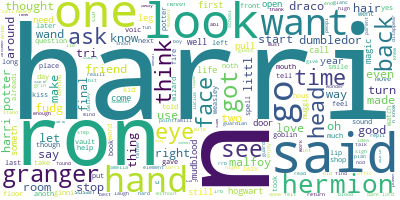

In [35]:
from wordcloud import WordCloud

_ = ''.join(list(str(df['text'].values)))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(_)

wordcloud.to_image()

Теперь соберем корпус для LDA модели

In [7]:
import gensim.corpora as corpora

df.dropna(inplace=True)
texts = df['text'].values.tolist()
dct = corpora.Dictionary(texts)

In [8]:
corpus = [dct.doc2bow(text) for text in texts]

In [9]:
from pprint import pprint
import gensim

num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dct,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"harri" + 0.016*"snape" + 0.010*"n" + 0.009*"look" + 0.008*"would" + '
  '0.007*"eye" + 0.006*"one" + 0.006*"could" + 0.006*"tom" + 0.006*"said"'),
 (1,
  '0.030*"n" + 0.022*"hermion" + 0.010*"could" + 0.009*"look" + 0.009*"would" '
  '+ 0.008*"know" + 0.007*"go" + 0.007*"like" + 0.007*"eye" + 0.007*"want"'),
 (2,
  '0.015*"n" + 0.010*"would" + 0.009*"could" + 0.008*"harri" + 0.007*"one" + '
  '0.007*"eye" + 0.007*"dark" + 0.007*"voldemort" + 0.006*"lord" + '
  '0.005*"death"'),
 (3,
  '0.019*"sirius" + 0.018*"n" + 0.018*"remus" + 0.009*"look" + 0.007*"like" + '
  '0.007*"eye" + 0.006*"could" + 0.006*"back" + 0.006*"scorpius" + '
  '0.006*"hand"'),
 (4,
  '0.013*"hermion" + 0.012*"n" + 0.008*"would" + 0.007*"said" + 0.007*"one" + '
  '0.006*"look" + 0.006*"back" + 0.006*"could" + 0.005*"go" + 0.005*"like"'),
 (5,
  '0.018*"n" + 0.015*"severus" + 0.009*"would" + 0.007*"said" + 0.007*"one" + '
  '0.006*"like" + 0.006*"know" + 0.006*"look" + 0.005*"could" + 0.005*"year"'),
 

In [15]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dct)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056139 -0.007338       1        1  14.537279
5     -0.000282 -0.054735       2        1  12.408176
8     -0.043485  0.021220       3        1  11.672066
1     -0.005012  0.029158       4        1  11.381660
9      0.008100  0.050603       5        1   9.842561
6     -0.050375 -0.024294       6        1   8.649216
4      0.010363 -0.003302       7        1   8.524668
0      0.025930 -0.013430       8        1   8.293808
3     -0.012919 -0.007756       9        1   8.223587
7      0.011541  0.009873      10        1   6.466980, topic_info=         Term          Freq         Total Category  logprob  loglift
1115    draco  4.612480e+05  4.612480e+05  Default  30.0000  30.0000
427     harri  1.195474e+06  1.195474e+06  Default  29.0000  29.0000
764       ron  3.338630e+05  3.338630e+05  Default  28.0000  28.0000
500      jame  1.967860e+05  1.967860e+05  Default  27.0000  27.0000
444   hermion  5.957750e+05  5.957750e+05  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
43        ask  1.773931e+04  3.126856e+05  Topic10  -5.7066  -0.1310
796       see  1.696853e+04  2.823563e+05  Topic10  -5.7510  -0.0733
429      head  1.691141e+04  2.878274e+05  Topic10  -5.7544  -0.0959
38     around  1.617406e+04  2.675041e+05  Topic10  -5.7990  -0.0673
1034     well  1.578165e+04  2.535780e+05  Topic10  -5.8235  -0.0384

[997 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
96615      6  0.965419     aaaach
7422       1  0.045474  aberforth
7422       2  0.116624  aberforth
7422       3  0.035575  aberforth
7422       4  0.012993  aberforth
...      ...       ...        ...
26725      4  0.910838     zoltan
26725      5  0.003673     zoltan
26725      6  0.003673     zoltan
17551      1  0.028911      zusak
17551      5  0.954048      zusak

[4399 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 9, 2, 10, 7, 5, 1, 4, 8])

Найдите еще что-то интересное в корпусе (что-то специфичное для фанфиков или фентези-тематики)

- в корпусе заметны большое количество глаголов (фанфики - чаще художественные произведения, не описательные)
- в топ частотности не попали заклинания (а ожидалось, что будет)
- также в топ частотности не попали слова из тематики 18+ (что ожидалось для фанфиков с высоким возрастным рейтингом)

## Bigrams

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [ ]:
sent = (word_tokenize(row) for row in df_cleaned['clean'].values)

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 11:15:51: collecting all words and their counts
INFO - 11:15:51: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:17:33: PROGRESS: at sentence #10000, processed 83261035 words and 11866288 word types
INFO - 11:18:57: PROGRESS: at sentence #20000, processed 144564114 words and 16354230 word types
INFO - 11:20:06: PROGRESS: at sentence #30000, processed 205067470 words and 20042152 word types
INFO - 11:21:04: collected 22250074 token types (unigram + bigrams) from a corpus of 245945660 words and 36225 sentences
INFO - 11:21:04: merged Phrases<22250074 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 11:21:04: Phrases lifecycle event {'msg': 'built Phrases<22250074 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 313.01s', 'datetime': '2022-11-13T11:21:04.071713', 'gensim': '4.2.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 

In [ ]:
bigram = Phraser(phrases)

INFO - 11:24:21: exporting phrases from Phrases<22250074 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 11:24:59: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<16701 phrases, min_count=30, threshold=10.0> from Phrases<22250074 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 38.83s', 'datetime': '2022-11-13T11:24:59.868854', 'gensim': '4.2.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [ ]:
sentences = bigram[sent]

# Model

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
from time import time

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 12:15:36: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-11-13T12:15:36.572367', 'gensim': '4.2.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [ ]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:16:07: collecting all words and their counts
INFO - 12:16:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:18:22: PROGRESS: at sentence #10000, processed 58969524 words, keeping 127295 word types
INFO - 12:19:44: collected 163523 word types from a corpus of 95186420 raw words and 15640 sentences
INFO - 12:19:44: Creating a fresh vocabulary
INFO - 12:19:44: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 39175 unique words (23.96% of original 163523, drops 124348)', 'datetime': '2022-11-13T12:19:44.959600', 'gensim': '4.2.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
INFO - 12:19:44: Word2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 94801504 word corpus (99.60% of original 95186420, drops 384916)', 'datetime': '2022-11-13T12:19:44.960596', 'gensim': '4.2.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, 

Time to build vocab: 3.63 mins


# Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

## Похожие слова

In [ ]:
w2v_model.wv.most_similar('potter')

[('leglimen', 0.2541438341140747),
 ('breviti', 0.22715307772159576),
 ('solicit', 0.2246485948562622),
 ('send', 0.2235267460346222),
 ('thousand_pound', 0.2149457037448883),
 ('welt', 0.21069170534610748),
 ('awar', 0.20911087095737457),
 ('gum', 0.2081729769706726),
 ('blood_princ', 0.20759066939353943),
 ('unward', 0.206340491771698)]

In [ ]:
w2v_model.wv.most_similar("harri")

[('photo_op', 0.24679455161094666),
 ('previous_timelin', 0.23860497772693634),
 ('toffi', 0.2282932996749878),
 ('cathol', 0.21834053099155426),
 ('regain_semblanc', 0.20718353986740112),
 ('amplifi', 0.20445376634597778),
 ('walburga_orion', 0.20362350344657898),
 ('abbey', 0.20357558131217957),
 ('interrog', 0.20282956957817078),
 ('algeria', 0.19961759448051453)]

In [ ]:
w2v_model.wv.most_similar("seri")

[('shaw', 0.24912121891975403),
 ('naiv', 0.22378988564014435),
 ('conspiraci_commit', 0.2230985164642334),
 ('zonko_product', 0.21330466866493225),
 ('licoric_wand', 0.21298086643218994),
 ('saniti_intact', 0.20501169562339783),
 ('katharina', 0.2036609947681427),
 ('finish_sentenc', 0.20167529582977295),
 ('unfulfil', 0.1987932026386261),
 ('poppi', 0.19749796390533447)]

In [ ]:
w2v_model.wv.most_similar("weasley")

[('skim_articl', 0.2493833601474762),
 ('endow', 0.23486606776714325),
 ('boast', 0.22628340125083923),
 ('jensen', 0.22585880756378174),
 ('demetria', 0.2201601266860962),
 ('polic_offic', 0.21764007210731506),
 ('tenni_ball', 0.2161814272403717),
 ('pork_chop', 0.210181325674057),
 ('pyxi', 0.20694872736930847),
 ('lodg_throat', 0.20647576451301575)]

In [ ]:
w2v_model.wv.most_similar("man")

[('levina_snowpet', 0.24843233823776245),
 ('vagu_recollect', 0.22844737768173218),
 ('uneasili', 0.22669363021850586),
 ('revit', 0.2069297730922699),
 ('masquerad_ball', 0.20403948426246643),
 ('irish_accent', 0.20381763577461243),
 ('survey_handiwork', 0.20375379920005798),
 ('sunni_saturday', 0.20079606771469116),
 ('richardson', 0.19944995641708374),
 ('quieten', 0.19879494607448578)]

## Аналоги

In [ ]:
w2v_model.wv.most_similar(positive=['potter', 'weasley'], negative=['woman'])

[('toe_boot', 0.22533637285232544),
 ('micah', 0.21792066097259521),
 ('ome', 0.2053540199995041),
 ('kick_shoe', 0.20485125482082367),
 ('earthen', 0.20243537425994873),
 ('cleverest', 0.20197592675685883),
 ('cedrella', 0.19894477725028992),
 ('sensor', 0.19776201248168945),
 ('traitor_midst', 0.19527402520179749),
 ('gladston', 0.19505605101585388)]

In [ ]:
w2v_model.wv.most_similar(positive=["love", "hate"], negative=["harri"])

[('porteous', 0.22383497655391693),
 ('tatter', 0.21526843309402466),
 ('discredit', 0.21444016695022583),
 ('eet_eez', 0.21406425535678864),
 ('carol', 0.21066389977931976),
 ('dross', 0.20711426436901093),
 ('helen', 0.20628459751605988),
 ('sorr', 0.20571251213550568),
 ('profession_athlet', 0.20512434840202332),
 ('outstrip', 0.20488429069519043)]

## Лишние слова

In [ ]:
w2v_model.wv.doesnt_match('scari dad zombi'.split())

'dad'

In [ ]:
w2v_model.wv.doesnt_match(['malfoy', 'harri', 'potter'])

'malfoy'

# Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.cm as cm

In [ ]:
most_popular_words = w2v_model.wv.index_to_key[:1000]
embeddings = w2v_model.wv[most_popular_words]

In [ ]:
n, m = embeddings.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
data_tsne = tsne_model_en_2d.fit_transform(embeddings)

In [ ]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

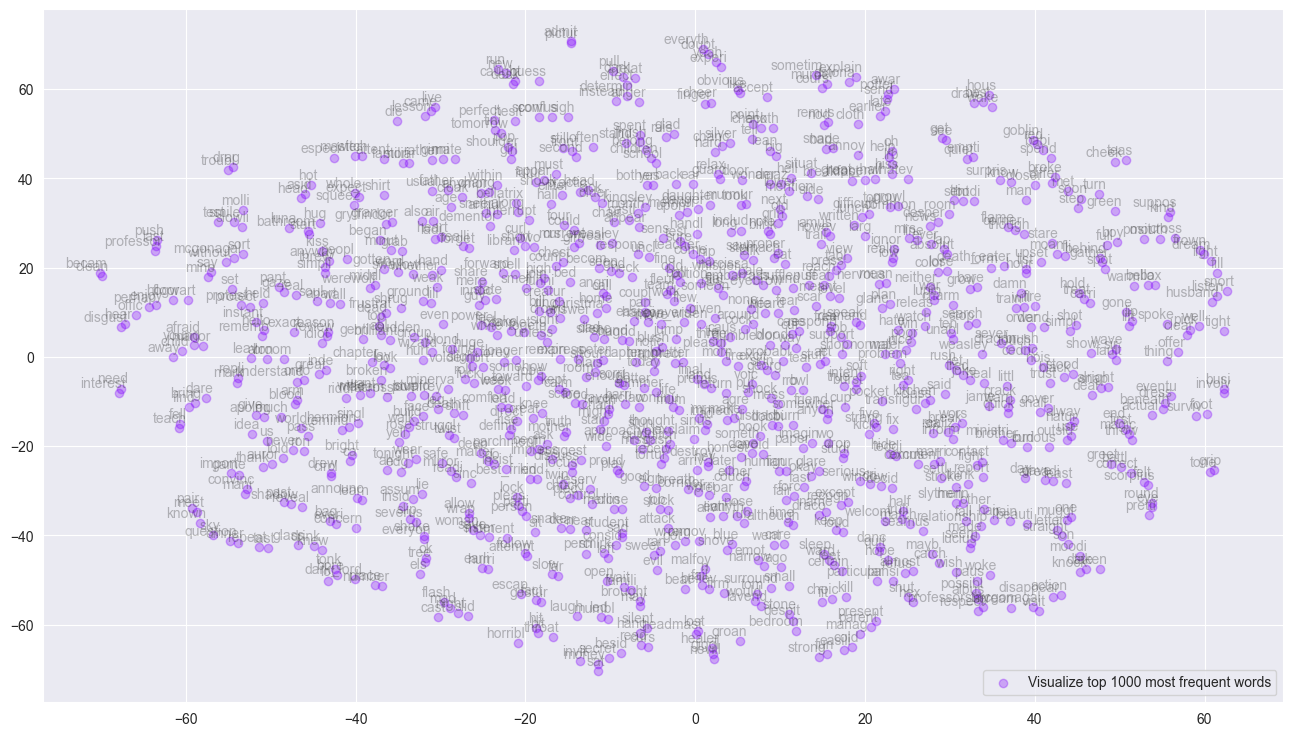

In [ ]:
tsne_plot_2d('Visualize top 1000 most frequent words', data_tsne, most_popular_words, a=0.3)

## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная м## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro $F_1$.
Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов. 

1. [1 балл] Используйте fastText в качестве baseline-классификатора.
2. [2 балла] Используйте сверточные  или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling. 
3. [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

[бонус] Используйте результат max pooling'а как эмбеддинг входного текста. Визуализируйте эмбеддинги 500-1000 предложений из обучающего множества и изучите свойства получившегося пространства.

[бонус] Используйте ваш любимый классификатор и любые (честные) способы повышения качества классификации и получите macro $F_1$ больше 0.5.

## Выполнение Части 3

**Важно**: все используемые ниже результаты воспроизводимы и хранятся в папке **part3_files**.

In [1]:
# !wget  https://www.dropbox.com/s/gwfgmomdbetvdye/hpac_lower_tokenized.zip
# !unzip hpac_lower_tokenized
# !unzip hpac_splits

In [5]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

import json
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загружаю данные согласно разбиению
df_train = pd.read_csv('hpac_corpus/hpac_training_128.tsv', sep = '\t', header = None)
df_val = pd.read_csv('hpac_corpus/hpac_dev_128.tsv', sep = '\t', header = None)
df_test = pd.read_csv('hpac_corpus/hpac_test_128.tsv', sep = '\t', header = None)

#### Предобработка данных

Перед тем, как обучать модели на текстах, их необходимо предобработать. Основные задачи для предобработки:
1. Убрать символы - кавычки, точки, запятые, а также обработать слова, которые их используют (например, *that 's*)
2. Избавиться от стоп-слов, которые не несут смысла, а также (по моему наблюдению) от слов длины 1 и 2, потому что в английском в 99% случаев это либо предлоги, союзы и т.п., либо обрезванные слова
3. А также, избавиться от дат формата *24th*, *15th*, поскольку для констекста заклинаний они не несут значимой информации
4. И в целом убрать числа, чтобы лишний раз не увеличивать размер словаря
5. Лемматизировать слова
6. Убрать короткие предложения из обучающей выборки

In [3]:
def prepare_texts(review_text):
    # Оставляем только буквенные символы
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Разбиваем на слова по символу пробела
    words = review_text.split()
    stops = stopwords.words("english")
    # Если длина лемматизированного слова <= 2, либо оно в стоп словах, либо не буква, то убираем
    words = [lemmatizer.lemmatize(w) for w in words if (not w in stops and not bool(re.search(r"[\W]+", w)) and len(lemmatizer.lemmatize(w)) > 2)]
    return(words)

In [4]:
lemmatizer = WordNetLemmatizer()

Предобработанные тексты будут храниться в отдельном поле **3**:

In [5]:
# Избавляемся от дат
df_train[3] = df_train[2].apply(lambda x: re.sub(r"[1-9]+[a-z]+", " ", x))
# Функция предобработки
df_train[3] = df_train[2].apply(lambda x: ' '.join(prepare_texts(x)))
# Удаляю короткие предложения из обучающей выборки, так как большинство текстов - длинные, и от коротких текстов будет мало пользы
df_train = df_train[df_train[3].apply(lambda x: len(x.split()) > 7)]

In [6]:
# Аналогично для валидации и теста
df_val[3] = df_val[2].apply(lambda x: re.sub(r"[1-9]+[a-z]+", " ", x))
df_val[3] = df_val[2].apply(lambda x: ' '.join(prepare_texts(x)))

df_test[3] = df_test[2].apply(lambda x: re.sub(r"[1-9]+[a-z]+", " ", x))
df_test[3] = df_test[2].apply(lambda x: ' '.join(prepare_texts(x)))

### Обучение FastText

In [7]:
# ! git clone https://github.com/facebookresearch/fastText.git
# ! pip3 install fastText/.

In [2]:
import fasttext

In [9]:
# Подготовим датасеты для работы с fasttext
def prepare_to_fasttext(df, dftype='train'):
    X = df[3].tolist()
    y = df[1].tolist()
    X, y = np.array(X), np.array(y)
    with open(dftype + '.txt', 'w+') as outfile:
        for i in range(len(X)):
            outfile.write('__label__' + y[i] + ' '+ X[i] + '\n')
            
prepare_to_fasttext(df_train, dftype='train')
prepare_to_fasttext(df_val, dftype='val')
prepare_to_fasttext(df_test, dftype='test')

In [10]:
# Функция для расчёта макро-f1
def get_macro_f1(df, model):
    res_tmp = df[3].apply(lambda x: model.predict(x)[0][0])
    res_tmp = res_tmp.apply(lambda x: x[x.rfind('_')+1:])
    return f1_score(df[1].values, res_tmp.values, average='macro')

In [50]:
# Обучение классификатора - я нашёл возможность автотюна под валидационную выборку и запустил обучение
classifier = fasttext.train_supervised(input='./part3_files/data/train.txt', autotuneValidationFile='./part3_files/data/val.txt', 
                                       autotuneDuration=600, autotuneMetric="f1")

Progress: 100.0% Trials:   14 Best score:  0.307955 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  43011
Number of labels: 85
Progress: 100.0% words/sec/thread:  289616 lr:  0.000000 avg.loss:  0.591634 ETA:   0h 0m 0s


In [51]:
# Макро F1 на тесте
get_macro_f1(df_test, classifier)

0.1197417030397155

In [3]:
# classifier.save_model("./part3_files/model_fasttext.bin")
classifier = fasttext.load_model("./part3_files/model_fasttext.bin")

#### Анализ результатов FastText

In [69]:
from sklearn.metrics import confusion_matrix
# Функция для получения confusion matrix для популярных и непопулярных классов 
def get_conf_matrix(classes, df, model):
    df_sliced = df[df[1].isin(list(classes))]
    res_tmp = df_sliced[3].apply(lambda x: model.predict(x)[0][0])
    res_tmp = res_tmp.apply(lambda x: x[x.rfind('_')+1:])
    df_cm = pd.DataFrame(confusion_matrix(df_sliced[1].values, res_tmp.values, 
                                          labels=list(classes)), index = [i for i in classes], 
                         columns = [i for i in classes])
    return df_cm

Сначала рассмотрим топ-10 популярных классов в тесте:

<AxesSubplot: >

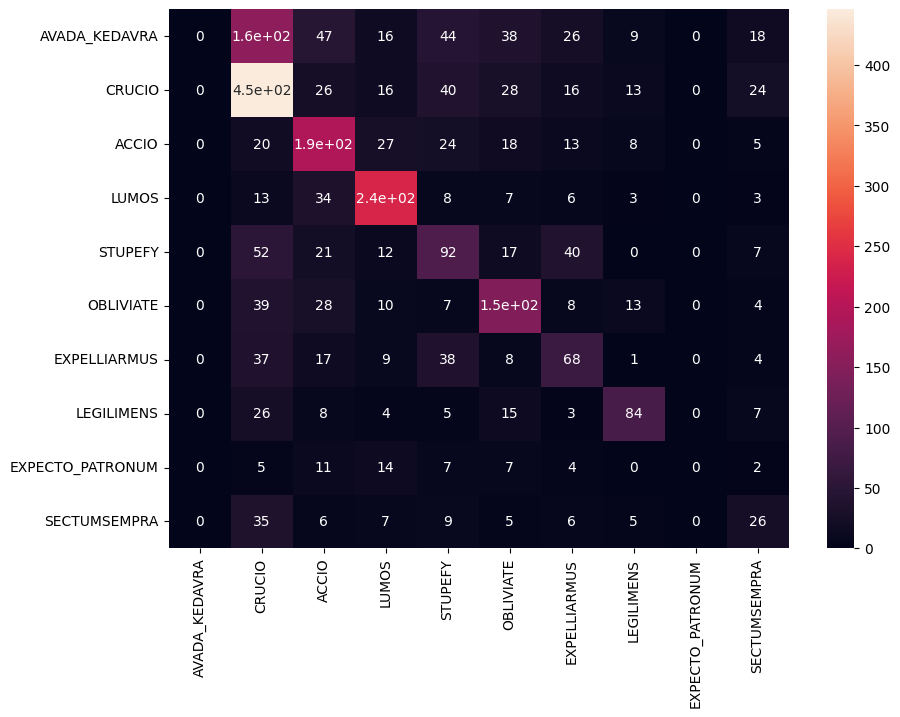

In [71]:
plt.figure(figsize = (10,7))
sn.heatmap(get_conf_matrix(pd.concat([df_train[1], df_val[1], df_test[1]]).value_counts(normalize=True).index[:10],
                           df_test, classifier), annot=True)

Удивительно, что полность путаются заклинания Avada Kedavra и Crucio, но они употрябляются в практически идентичных контекстах и означают смерть, пытки, мучение. Поэтому модель может их путать. Также Expecto Patronum путается с Lumos часто, и это заклинания оба символизируют вспышку света. И Stupefy часто путается с Crucio и Expelliarmus, посколько в этих констекстах человек часто обездвижен, обезоружен.

Теперь рассмотрим топ-30 самых непопулярных классов:

<AxesSubplot: >

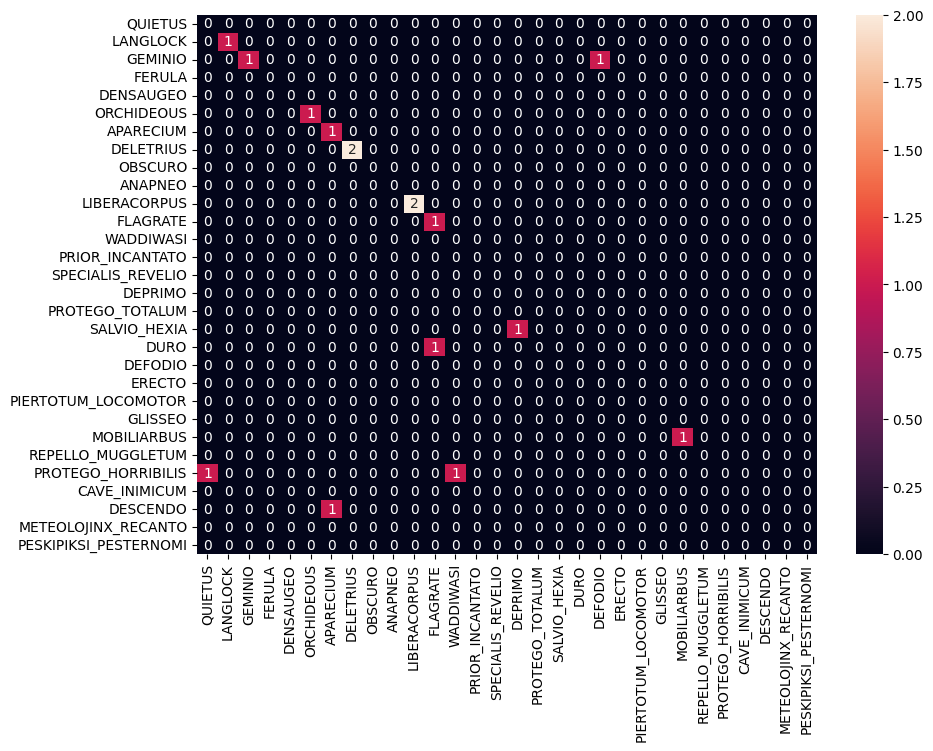

In [72]:
plt.figure(figsize = (10,7))
sn.heatmap(get_conf_matrix(pd.concat([df_train[1], df_val[1], df_test[1]]).value_counts(normalize=True).index[-30:],
                           df_test, classifier), annot=True)

Удивительно, но половину их этих действительно редких заклинаний модель определила правильно. Погуглив некотоыре из них, я понял, что у них всех разный смысл и употрябляются они в разных контекстах, поэтому их сложно спутать модели даже несмотря на то, что в датасете их представлено мало.

#### Обучение свёрточной сети

Для обучения свёрточной модели и экспериментов с параметрами был разработан модуль **cnn_model.py**, в котором реализована архитектура свёрточной модели, обучение с подбором параметров. Суть в том, что на вход подаётся список размеров ядер и количества фильтров (одинаковой длины), происходит обучение и валидация модели, а результат сохраняется в файл **results.json**. Весь процесс запускается через скрипт **models_training.sh**.

Были рассмотрены различные параметры и выбраны лучшие:

In [13]:
with open('./part3_files/results.json') as json_file:
    results_cnn = json.load(json_file)

In [15]:
for i in range(len(results_cnn['metrics_val'])):
    print('С ядрами {} и фильтрами {} результат на валидации равен  {}, а на тесте {}'.format(results_cnn['kernels'][i],
                                                                                             results_cnn['filters'][i],
                                                                                             round(results_cnn['metrics_val'][i],4),
                                                                                             round(results_cnn['metrics_test'][i],4)))
    print()

С ядрами [3] и фильтрами [5] результат на валидации равен  0.0558, а на тесте 0.0547

С ядрами [3, 5, 7, 9] и фильтрами [10, 15, 20, 30] результат на валидации равен  0.1284, а на тесте 0.1246

С ядрами [3, 5, 7] и фильтрами [10, 15, 20] результат на валидации равен  0.1146, а на тесте 0.1179

С ядрами [3, 5, 5, 3] и фильтрами [5, 7, 10, 15] результат на валидации равен  0.1173, а на тесте 0.1082

С ядрами [3, 3] и фильтрами [10, 10] результат на валидации равен  0.0672, а на тесте 0.0659

С ядрами [3, 6, 10] и фильтрами [5, 10, 30] результат на валидации равен  0.1227, а на тесте 0.1096



Несмотря на довольно схожие результаты, я решил выбрать модель под номером 1 (нумерация с 0) для дальнейшей работы. Также, хочется выделить то, что результаты не сильно обогнали fasttext..( Просто мои модели долго обучались, поэтому точный подбор параметров сделать было сложно.

### Аугментация данных

Для начала расммотрим соотношение всех классов в наборе данных:

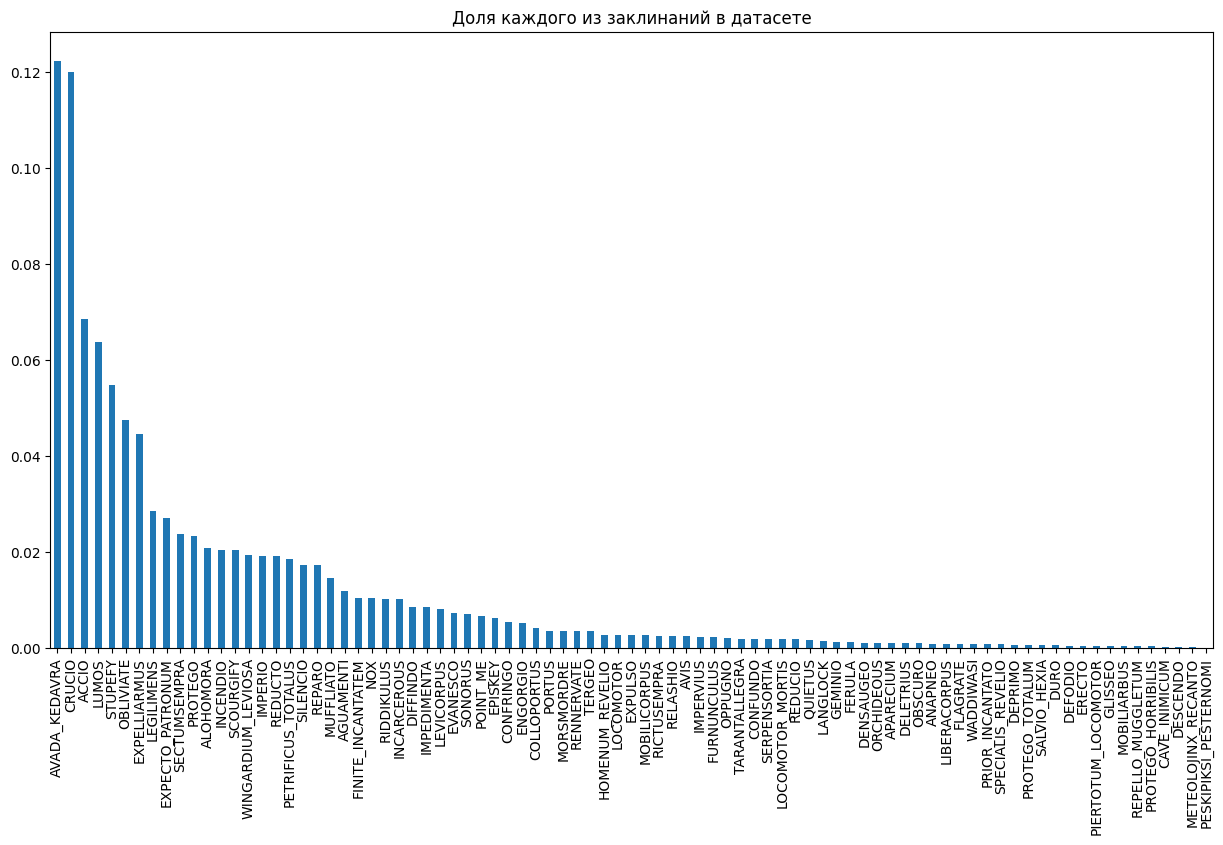

In [7]:
ax = pd.concat([df_train[1], df_val[1], df_test[1]]).value_counts(normalize=True).plot(kind='bar', figsize=(15,8))
plt.title('Доля каждого из заклинаний в датасете');

Видно, что из всех 85 заклинаний первые 10 занимают как миниум половину всех записей в датасете, что говорит о сильном дисбалансе классов. Попробуем его расширить! Для этого будем аугментировать все классы, кроме топ-10 с помощью:

1) Рандомной замены слова на синоним из WordNet
2) Рандомную перестановку слов
3) Рандомное удаление слова

In [54]:
import augmentation

In [58]:
augmented_df = []

In [59]:
for _, row in tqdm(df_train.iterrows()):
    if row[1] in df_train[1].value_counts().index[10:]:
        augmented_sentence = augmentation.augment_data(row[3])
        augmented_tmp = pd.DataFrame({3:[augmented_sentence], 1:[row[1]]})
        augmented_df.append(augmented_tmp)

60660it [02:00, 503.32it/s]


In [60]:
df_train_augmented = pd.concat([df_train[[3,1]], pd.concat(augmented_df)]).sample(frac=1).reset_index(drop=True)

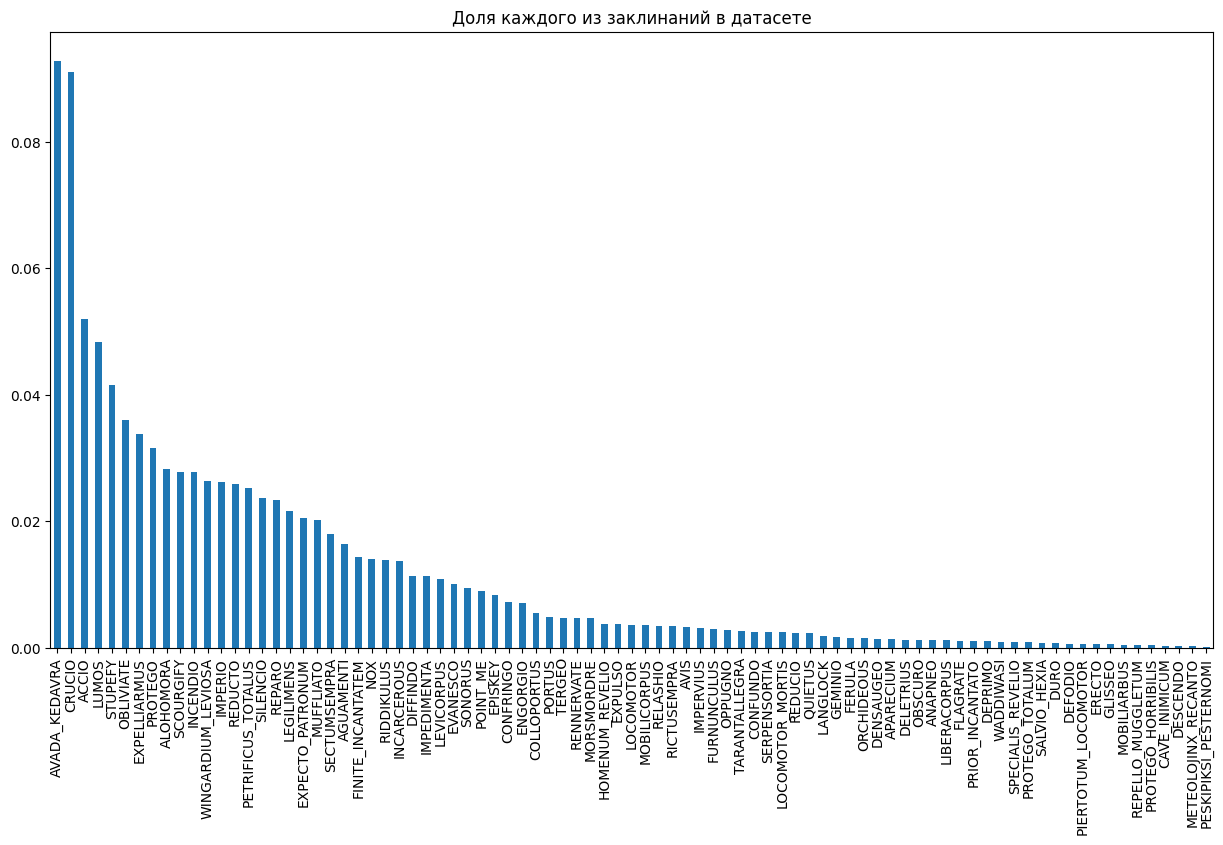

In [64]:
ax = pd.concat([df_train_augmented[1], df_val[1], df_test[1]]).value_counts(normalize=True).plot(kind='bar', figsize=(15,8))
plt.title('Доля каждого из заклинаний в датасете');

Пропорции численно изменились, сохраним полученный файл для обучения на нём:

In [65]:
df_train_augmented.to_csv('./part3_files/data/train_augmented.csv', index=False)

Обучим самую лучшую модель из прошлого задания на аугментированных данных и добавим в предыдущий файл, назвав его **results_new.json**:

In [16]:
with open('./part3_files/results_new.json') as json_file:
    results_cnn = json.load(json_file)

In [17]:
for i in range(len(results_cnn['metrics_val'])):
    print('С ядрами {} и фильтрами {} результат на валидации равен  {}, а на тесте {}'.format(results_cnn['kernels'][i],
                                                                                             results_cnn['filters'][i],
                                                                                             round(results_cnn['metrics_val'][i],2),
                                                                                             round(results_cnn['metrics_test'][i],2)))
    print()

С ядрами [3] и фильтрами [5] результат на валидации равен  0.06, а на тесте 0.05

С ядрами [3, 5, 7, 9] и фильтрами [10, 15, 20, 30] результат на валидации равен  0.12, а на тесте 0.11

С ядрами [3, 5, 7] и фильтрами [10, 15, 20] результат на валидации равен  0.11, а на тесте 0.12

С ядрами [3, 5, 5, 3] и фильтрами [5, 7, 10, 15] результат на валидации равен  0.12, а на тесте 0.11

С ядрами [3, 3] и фильтрами [10, 10] результат на валидации равен  0.07, а на тесте 0.07

С ядрами [3, 6, 10] и фильтрами [5, 10, 30] результат на валидации равен  0.12, а на тесте 0.11

С ядрами [3, 5, 7, 9] и фильтрами [10, 15, 20, 30] результат на валидации равен  0.14, а на тесте 0.14



Видно, что модель, обученная на аугментированных данных, дала прирост в метриках!

### Визуализация пространства эмбеддингов

In [105]:
from cnn_model import CNN
import torch
from torchtext.legacy import data

Для начала загрузим модель с предыдущего пункта (код с модуля cnn_model.py):

In [140]:
train_data, valid_data, test_data = data.TabularDataset.splits(
    path = './',
    train='part3_files/data/train_augmented.csv',
    validation='part3_files/data/val_edited.csv',
    test='part3_files/data/test_edited.csv',
    format='csv',
    skip_header=True,
    fields=[('text', TEXT),
        ('label', LABEL)]
)
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort=False,
    batch_size=BATCH_SIZE,
    device=device)

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
FILTERS = [10, 15, 20, 30]
KERNELS = [3, 5, 7, 9]
OUTPUT_DIM = len(set(list(train_data.label)))

In [141]:
# Вызов модели
model = CNN(INPUT_DIM, EMBEDDING_DIM, FILTERS, KERNELS, OUTPUT_DIM, DROPOUT_PROBA).to(device)
model.load_state_dict(torch.load('./part3_files/data/cnn_0.pt', map_location=device))
model.eval()

Создадим хук для сохранения параметров слоя MaxPooling-а при подаче текста в модель:

In [172]:
# 
embeddings = []
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.pooling.register_forward_hook(get_activation('pooling'))
with torch.no_grad():
    for batch in test_iterator:
        logits = model(batch.text)
        embeddings.extend(activation['pooling'].squeeze().detach().cpu().numpy())

Визуализация будет роисходить с помощью алгоритма t-SNE:

In [182]:
from sklearn.manifold import TSNE

In [187]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca').fit_transform(np.array(embeddings[:750]))

/media/ssd-3t/isviridov/mdetr_work/nlp_tasks/nlp_tasks/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


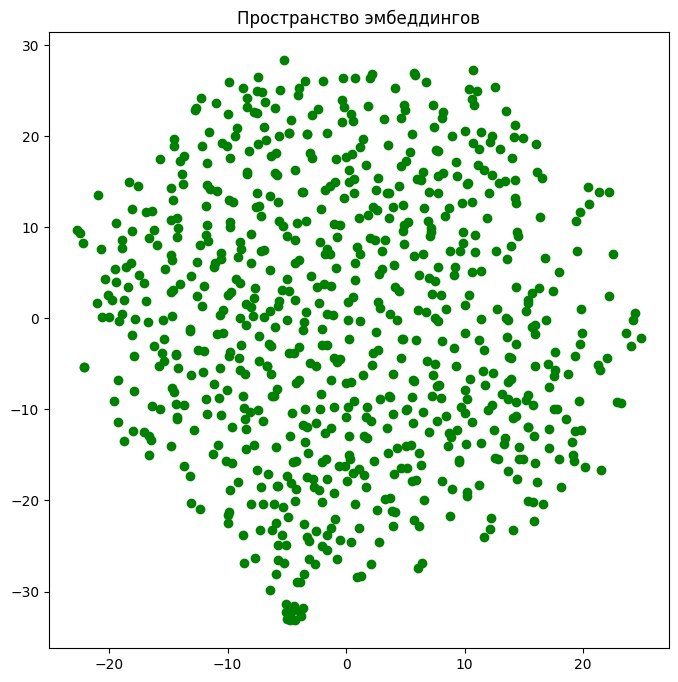

In [189]:
fig, ax = plt.subplots()

ax.scatter(X_embedded[:,0], X_embedded[:,1],
           c = 'green')
ax.set_title('Пространство эмбеддингов')

fig.set_figwidth(8)
fig.set_figheight(8)

plt.show()

Видно, что пространство похоже больше на рандомное, однако, выделяются островки текстов, что говорит о том, что модель может улавливать некоторые закономерности в пространстве. 

## Часть 4. [1 балл] Итоги
Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

Часть 1. 
1. Регулярками были токенизированы слова, переведены к нижнему регистру и удалены стоп-слова, отрисованы топ-10.  
2. Регулярками выделены кандидаты, написана итоговая таблица, предварительно почищенная руками.

Бонусы.
1. Была построена и обучена тематическая модель LDA на всем корпусе, визулизация реализована с помощью pyLDAvis. Было выделено 10 тем: по осям можно проследить разделение фанфиков по участвующим персонажам и действиям. Например, Гарри+Драко, Северус+Альбус или Гарри+Пожиратели смерти.
2. Для фанфиков (как коротких событийных рассказов) было найдено большое число глаголов действий.

Часть 2.
1. Построил биграммы по очищенным данным. 
2. Обучил модель Word2Vec
3. Продемонстрировал поиск синонимов, лишних слов
4. Построил визуализацию tSNE самых популярных слов

Часть 3.
1. Были предобработаны тексты из набора данных для обучения, валидации и тестирования модели
2. Обучена модель FastText с режимом подбора параметров
3. Проанализированы результаты по популярным и редким классам
4. Разработана свёрточная модель, обучены несколько вариантов, выбран лучший согласно валидации
5. Проведена аугментация данных путём расширения непопулярных классов через замену на синонимы из WordNet, удаления, либо перестановки слов
6. Обучена модель на полученных данных
6. Визуализированы эмбеддинги MaxPool-слоя этой модели

По мере работы стало понятно, как важна предобработка данных и соблюдение баланса классов. В задачах работы с текстом это особенно важно, поскольку похожий контекст вносит сильное смщение в работу модели, помимо дисбаланса, что усложняет обучение. Поэтому следует вручную просматривать результаты работы модели и анализировать их. Чтение Гарри Поттера помогло в изучении контекста предложений, а также выявления схожих заклинаний (классов). Также хочется сказать, что необязательно прибегать к сложным архитектурам, так как они могут работать схоже с бейзлайнами!